# 目录
- 核心组件：model | tool | system prompt
- 唤起Agent
- 进阶概念：结构化输出 | 记忆 | 流 | 中间件

# **LangChain** 对 Agent 的一段定义：     
Agents combine language models with tools to create systems that can reason about tasks, decide which tools to use, and iteratively work towards solutions.     
**核心点：链接模型与工具，迭代求解**

其他一些有意思的表述：      
An LLM Agent runs tools in a loop to achieve a goal.    

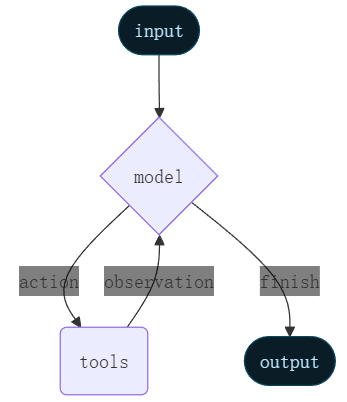


***Info:***

[`create_agent`](https://reference.langchain.com/python/langchain/agents/#langchain.agents.create_agent) builds a **graph**-based agent runtime using [LangGraph](/oss/python/langgraph/overview). A graph consists of nodes (steps) and edges (connections) that define how your agent processes information. The agent moves through this graph, executing nodes like the model node (which calls the model), the tools node (which executes tools), or middleware.

Learn more about the [Graph API](/oss/python/langgraph/graph-api).

# 2 Core components
- Model
- Tools
- System prompt

## 2.1 Model
**加载模型**有两种方式：
1. Static model：在创建代理时指定一次就不再变更，是最经典和常用的方式
    ````py
    from langchain.agents import create_agent
    from langchain_openai import ChatOpenAI

    model = ChatOpenAI(model,openai_api_key)

    agent = create_agent(
        model = model,
        tools=tools
    )
    ````
2. Dynamic model:创建多个模型实例，Agent运行时 动态选择，要使用动态模型，create middleware using the @wrap_model_call（参看[langchain/v1.ipynb](../v1.ipynb)） decorator that modifies the model in the request:     
    ````py
        from langchain_openai import ChatOpenAI
        from langchain.agents import create_agent
        from langchain.agents.middleware import wrap_model_call, ModelRequest, ModelResponse


        basic_model = ChatOpenAI(model="gpt-4o-mini")
        advanced_model = ChatOpenAI(model="gpt-4o")

        @wrap_model_call
        def dynamic_model_selection(request: ModelRequest, handler) -> ModelResponse:
            """Choose model based on conversation complexity."""
            message_count = len(request.state["messages"])

            if message_count > 10:
                # Use an advanced model for longer conversations
                model = advanced_model
            else:
                model = basic_model

            request.model = model
            return handler(request)

        agent = create_agent(
            model=basic_model,  # Default model
            tools=tools,
            middleware=[dynamic_model_selection]
        )
    ````

## 2.2 Defining tools
Pass **a list** of tools to the agent.代码不贴了，还是写 tool 函数，并加 @tool 装饰，创建 Agent 时用一个 list 注册即可

### 2.2.1 Tool error handling
通过 @wrap_tool_call 装饰器处理

# 2.3 System prompt
Dynamic system prompt ，动态的 系统提示词 可以 借助  @dynamic_prompt decorator 实现一个 middleware

# 3 Invocation

````py
result = agent.invoke(
    {"messages": [{"role": "user", "content": "What's the weather in San Francisco?"}]}
)
````

For streaming steps and / or tokens from the agent, refer to the [streaming](https://docs.langchain.com/oss/python/langchain/streaming) guide.

# 4 Advanced concepts
## 4.1 Structured output
- from langchain.agents.structured_output import ToolStrategy
- from langchain.agents.structured_output import ProviderStrategy

## 4.2 Memory
Agent 通过 message state maintain 会话历史。state 是？以及，我们也可以通过 custom state schema 来记录对话中的一些信息。     
自定义有两种方式，写法上略有不同，前者可以对 state extensions 限制在相关的中间件或工具内，参看[原文档:Memory](https://docs.langchain.com/oss/python/langchain/agents#memory) ：
1. Via middleware (preferred)
2. Via state_schema on create_agent

# 5 Streaming
If the agent executes multiple steps, this may **take a while**.        
关于 chunk 的划分参看 Streaming 文档。一段示例代码：
````py
for chunk in agent.stream({
    "messages": [{"role": "user", "content": "Search for AI news and summarize the findings"}]
}, stream_mode="values"):
    # Each chunk contains the full state at that point
    latest_message = chunk["messages"][-1]
    if latest_message.content:
        print(f"Agent: {latest_message.content}")
    elif latest_message.tool_calls:
        print(f"Calling tools: {[tc['name'] for tc in latest_message.tool_calls]}")
````

# 6 Middleware
中间件 ，参看 [Middleware](https://docs.langchain.com/oss/python/langchain/middleware)